## Rotate images properly

In [1]:
import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
import seaborn as sns
from skimage import img_as_ubyte
import os
import math
from skimage.util import random_noise
from scipy import signal
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
sns.set()

In [2]:
img = cv2.imread(r'image/aug/aug_353-shruthi_17.jpeg')

In [3]:
# convert the image to grayscale and flip the foreground and background to ensure foreground is now "white" and
# the background is "black"
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
# threshold the image, setting all foreground pixels to 255 and all background pixels to 0
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

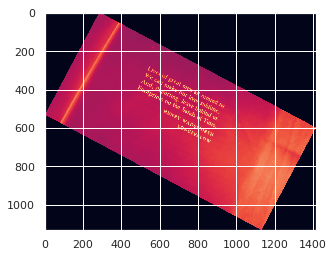

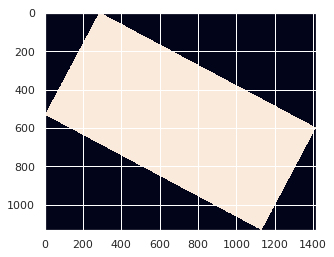

In [4]:
plt.imshow(gray)
plt.show()

plt.imshow(thresh)
plt.show()

In [5]:
# grab the (x, y) coordinates of all pixel values that are greater than zero, then use these coordinates to
# compute a rotated bounding box that contains all coordinates
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
# the `cv2.minAreaRect` function returns values in the range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we need to add 90 degrees to the angle
print(angle)
if angle < -45:
    angle = -(90 + angle)
    print("Less than -45", angle)
# otherwise, just take the inverse of the angle to make it positive
else:
    angle = -angle
    print("Greater than -45", angle)

-27.979473114013672
Greater than -45 27.979473114013672


In [6]:
# rotate the image to deskew it
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

In [7]:
print(angle)

27.979473114013672


[INFO] angle: 27.979


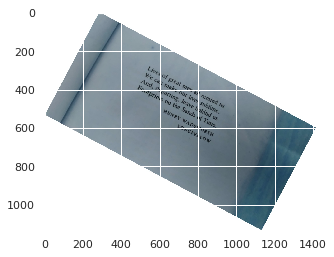

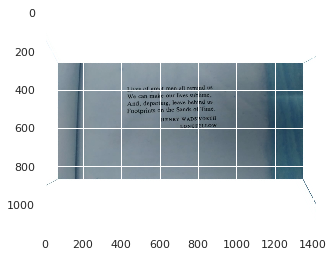

In [8]:
# show the output image
print("[INFO] angle: {:.3f}".format(angle))
plt.imshow(img)
plt.show()
plt.imshow(rotated)
plt.show()

In [ ]:
## (1) Convert to gray, and threshold
gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

## (2) Morph-op to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

## (3) Find the max-area contour
cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]

## (4) Crop and save it
x,y,w,h = cv2.boundingRect(cnt)
dst = rotated[y:y+h, x:x+w]
plt.imshow(dst)
plt.show()
# cv2.imwrite('1.jpg', dst)

## GrayScale conversion

In [ ]:
img_paths=os.listdir('image/train_cleaned')
img_paths=['image/train_cleaned/'+x for x in img_paths]

cleaned_img=[cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in img_paths]
print(type(cleaned_img), len(cleaned_img))

In [ ]:
img_paths=os.listdir('image/train')
img_paths=['image/train/'+x for x in img_paths]
dirty_img=[cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in img_paths]
print(type(dirty_img), len(dirty_img), dirty_img[0].shape)

In [9]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
#     print(img)
    img = cv2.resize(img, (540, 500))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print("Image after resizing and converting to grayscale", img)
    img = img/255.0
    img = np.reshape(img, (500, 540, 1))
    
    return img

In [16]:
original_image = []
original_path = 'image/train/'
for im in os.listdir(original_path):  # read image name from folder and append its path into "images" array     
    filename = (os.path.join(original_path,im))
    if(filename.endswith('.txt')==False):
        print(filename)
        original_image.append(process_image(filename))
print(im)
# gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY) 
# final_image = (process_image('image/train/101.png'))

image/train/68.png
image/train/32.png
image/train/113.png
image/train/27.png
image/train/15.png
image/train/129.png
image/train/45.png
image/train/30.png
image/train/89.png
image/train/aparna_19.jpeg
image/train/158.png
image/train/153.png
image/train/20.png
image/train/143.png
image/train/2.png
image/train/77.png
image/train/168.png
image/train/191.png
image/train/165.png
image/train/125.png
image/train/167.png
image/train/141.png
image/train/116.png
image/train/161.png
image/train/shakkthi_13.jpeg
image/train/86.png
image/train/shruthi_17.jpeg
image/train/188.png
image/train/29.png
image/train/101.png
image/train/144.png
image/train/192.png
image/train/57.png
image/train/174.png
image/train/12.png
image/train/69.png
image/train/shakkthi_27.jpeg
image/train/128.png
image/train/146.png
image/train/shakkthi_22.jpeg
image/train/50.png
image/train/212.png
image/train/159.png
image/train/47.png
image/train/36.png
image/train/shruthi_18.jpeg
image/train/95.png
image/train/shruthi_7.jpeg
ima

In [17]:
print(len(original_image),original_image[0].shape)

175 (500, 540, 1)


In [18]:
train_cleaned = []
traincleaned_path = 'image/train_cleaned/'
for im in os.listdir(traincleaned_path):  # read image name from folder and append its path into "images" array     
    filename = (os.path.join(traincleaned_path,im))
    if(filename.endswith('.txt')==False):
        print(filename)
        train_cleaned.append(process_image(filename))
# print(im)

image/train_cleaned/68.png
image/train_cleaned/32.png
image/train_cleaned/113.png
image/train_cleaned/27.png
image/train_cleaned/15.png
image/train_cleaned/129.png
image/train_cleaned/45.png
image/train_cleaned/30.png
image/train_cleaned/89.png
image/train_cleaned/aparna_19.jpeg
image/train_cleaned/158.png
image/train_cleaned/153.png
image/train_cleaned/20.png
image/train_cleaned/143.png
image/train_cleaned/2.png
image/train_cleaned/77.png
image/train_cleaned/168.png
image/train_cleaned/191.png
image/train_cleaned/165.png
image/train_cleaned/125.png
image/train_cleaned/167.png
image/train_cleaned/141.png
image/train_cleaned/116.png
image/train_cleaned/161.png
image/train_cleaned/shakkthi_13.jpeg
image/train_cleaned/86.png
image/train_cleaned/shruthi_17.jpeg
image/train_cleaned/188.png
image/train_cleaned/29.png
image/train_cleaned/101.png
image/train_cleaned/144.png
image/train_cleaned/192.png
image/train_cleaned/57.png
image/train_cleaned/174.png
image/train_cleaned/12.png
image/train

In [19]:
print(len(train_cleaned),train_cleaned[0].shape)

175 (500, 540, 1)


In [15]:
original_path = 'image/aug/'
for im in os.listdir(original_path):  # read image name from folder and append its path into "images" array     
    filename = (os.path.join(original_path,im))
    if(filename.endswith('.txt')==False):
        print(filename)
        original_image.append(process_image(filename))

image/aug/aug_857-24.png
image/aug/aug_514-41.png
image/aug/aug_773-203.png
image/aug/aug_897-98.png
image/aug/aug_955-17.png
image/aug/aug_656-60.png
image/aug/aug_136-27.png
image/aug/aug_775-201.png
image/aug/aug_334-95.png
image/aug/aug_906-aparna_19.jpeg
image/aug/aug_241-shruthi_15.jpeg
image/aug/aug_901-83.png
image/aug/aug_232-aparna_13.jpeg
image/aug/aug_300-15.png
image/aug/aug_40-174.png
image/aug/aug_818-17.png
image/aug/aug_613-shakkthi_14.jpg
image/aug/aug_414-39.png
image/aug/aug_277-66.png
image/aug/aug_492-117.png
image/aug/aug_923-5.png
image/aug/aug_687-59.png
image/aug/aug_215-165.png
image/aug/aug_358-aparna_26.jpeg
image/aug/aug_578-198.png
image/aug/aug_145-shruthi_15.jpeg
image/aug/aug_934-179.png
image/aug/aug_571-30.png
image/aug/aug_688-141.png
image/aug/aug_854-shruthi_8.jpg
image/aug/aug_724-aparna_6.jpeg
image/aug/aug_718-194.png
image/aug/aug_846-86.png
image/aug/aug_657-59.png
image/aug/aug_549-39.png
image/aug/aug_796-8.png
image/aug/aug_611-176.png
ima

image/aug/aug_77-158.png
image/aug/aug_823-18.png
image/aug/aug_698-71.png
image/aug/aug_319-59.png
image/aug/aug_515-45.png
image/aug/aug_131-114.png
image/aug/aug_726-105.png
image/aug/aug_198-137.png
image/aug/aug_185-83.png
image/aug/aug_706-9.png
image/aug/aug_480-179.png
image/aug/aug_679-27.png
image/aug/aug_658-149.png
image/aug/aug_264-42.png
image/aug/aug_188-shruthi_7.jpeg
image/aug/aug_985-35.png
image/aug/aug_992-69.png
image/aug/aug_700-68.png
image/aug/aug_552-165.png
image/aug/aug_917-shruthi_15.jpeg
image/aug/aug_568-170.png
image/aug/aug_977-shruthi_8.jpg
image/aug/aug_445-192.png
image/aug/aug_237-131.png
image/aug/aug_421-56.png
image/aug/aug_792-69.png
image/aug/aug_90-shruthi_27.jpg
image/aug/aug_491-119.png
image/aug/aug_323-21.png
image/aug/aug_907-aparna_20.jpeg
image/aug/aug_864-60.png
image/aug/aug_313-shakkthi_27.jpg
image/aug/aug_755-179.png
image/aug/aug_15-192.png
image/aug/aug_649-102.png
image/aug/aug_490-201.png
image/aug/aug_112-18.png
image/aug/aug_4

KeyboardInterrupt: 

In [ ]:
print(len(original_image), original_image[0].shape)

In [20]:
# convert list to numpy array
X_train = np.asarray(original_image)
Y_train = np.asarray(train_cleaned)
# X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [21]:
def model():
    input_layer = Input(shape=(500, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 420, 540, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 420, 540, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 420, 540, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 210, 270, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 210, 270, 64)     

In [ ]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=2, batch_size=24, verbose=0, callbacks=[callback])